In [1]:
from pathlib import Path

import yaml
import polars as pl
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scienceplots

In [2]:
plt.style.use(['science','ieee'])

In [3]:
window_size = 70

---

In [4]:
paths = [
    path.parent
    for path in Path('../sweep/n_episodes_501/').glob('**/**/*.csv')
]
len(paths)

80

In [5]:
dfs = list()
for elem in paths:
    cpath = elem / '.hydra/config.yaml'
    with open(cpath, 'r') as f:
        cfg = yaml.load(f, yaml.Loader)

    cfg.pop('interactive')

    df = pd.json_normalize(cfg)
    df['path'] = str(elem)
    dfs.append(df)

In [6]:
concat = pl.DataFrame(pd.concat(dfs))

In [7]:
results = list()
for row in concat.iter_rows():
    path = Path(row[-1]) / 'cartp__times.csv'

    times = (
        pl.read_csv(path, has_header=False)
        .mean_horizontal()
        .rolling_mean(window_size=window_size)
        .slice(length=1, offset=-1)
        .item()
    )

    results.append({'path': row[-1], 'times': times})

In [8]:
results_df = (
    concat
    .join(pl.DataFrame(results), on='path', how='left')
)

In [9]:
for col in results_df.columns[:-3]:
    print(col)
    print(
        results_df
        .group_by(col)
        .agg(
            pl.median('times').alias('times_median'),
            pl.mean('times').alias('times_mean'),
        )
        .sort('times_mean', descending=True)
    )

n_episodes
shape: (1, 3)
┌────────────┬──────────────┬────────────┐
│ n_episodes ┆ times_median ┆ times_mean │
│ ---        ┆ ---          ┆ ---        │
│ i64        ┆ f64          ┆ f64        │
╞════════════╪══════════════╪════════════╡
│ 501        ┆ 298.707143   ┆ 258.30125  │
└────────────┴──────────────┴────────────┘
n_observations
shape: (7, 3)
┌────────────────┬──────────────┬────────────┐
│ n_observations ┆ times_median ┆ times_mean │
│ ---            ┆ ---          ┆ ---        │
│ i64            ┆ f64          ┆ f64        │
╞════════════════╪══════════════╪════════════╡
│ 0              ┆ 370.357143   ┆ 288.103571 │
│ 1              ┆ 326.792857   ┆ 268.5      │
│ 6              ┆ 281.9        ┆ 250.189286 │
│ 2              ┆ 280.078571   ┆ 249.957143 │
│ 4              ┆ 270.585714   ┆ 246.783929 │
│ 3              ┆ 241.021429   ┆ 237.125    │
│ 5              ┆ 230.135714   ┆ 235.792857 │
└────────────────┴──────────────┴────────────┘
model_params.batch_size
shape: (2,

In [10]:
def read_times(path_: str, idx: int):
    return (
        pl.read_csv(Path(path_) / 'cartp__times.csv', has_header=False)
        .rename({'column_1': f'exec_{idx:02d}'})
    )

In [11]:
def plot_cmp(colname: str, title: str):
    ax = plt.gca()

    opts = list(results_df.select(colname).unique().iter_rows())
    for name, in opts:
        col_paths = (
            results_df
            .filter(pl.col(colname) == name)
            .select('path')
        )

        (
            pl.concat(
                [read_times(elem[0], i)
                for i, elem in enumerate(col_paths.iter_rows())],
                how='horizontal'
            )
            .mean_horizontal()
            .rolling_mean(window_size=window_size)
            .to_pandas()
            .plot(ax=ax, alpha=0.5, label=name)
        )

    plt.legend()
    plt.ylabel('Total Time')
    plt.xlabel('Episodes')
    plt.title(title)
    plt.show()
    plt.close()

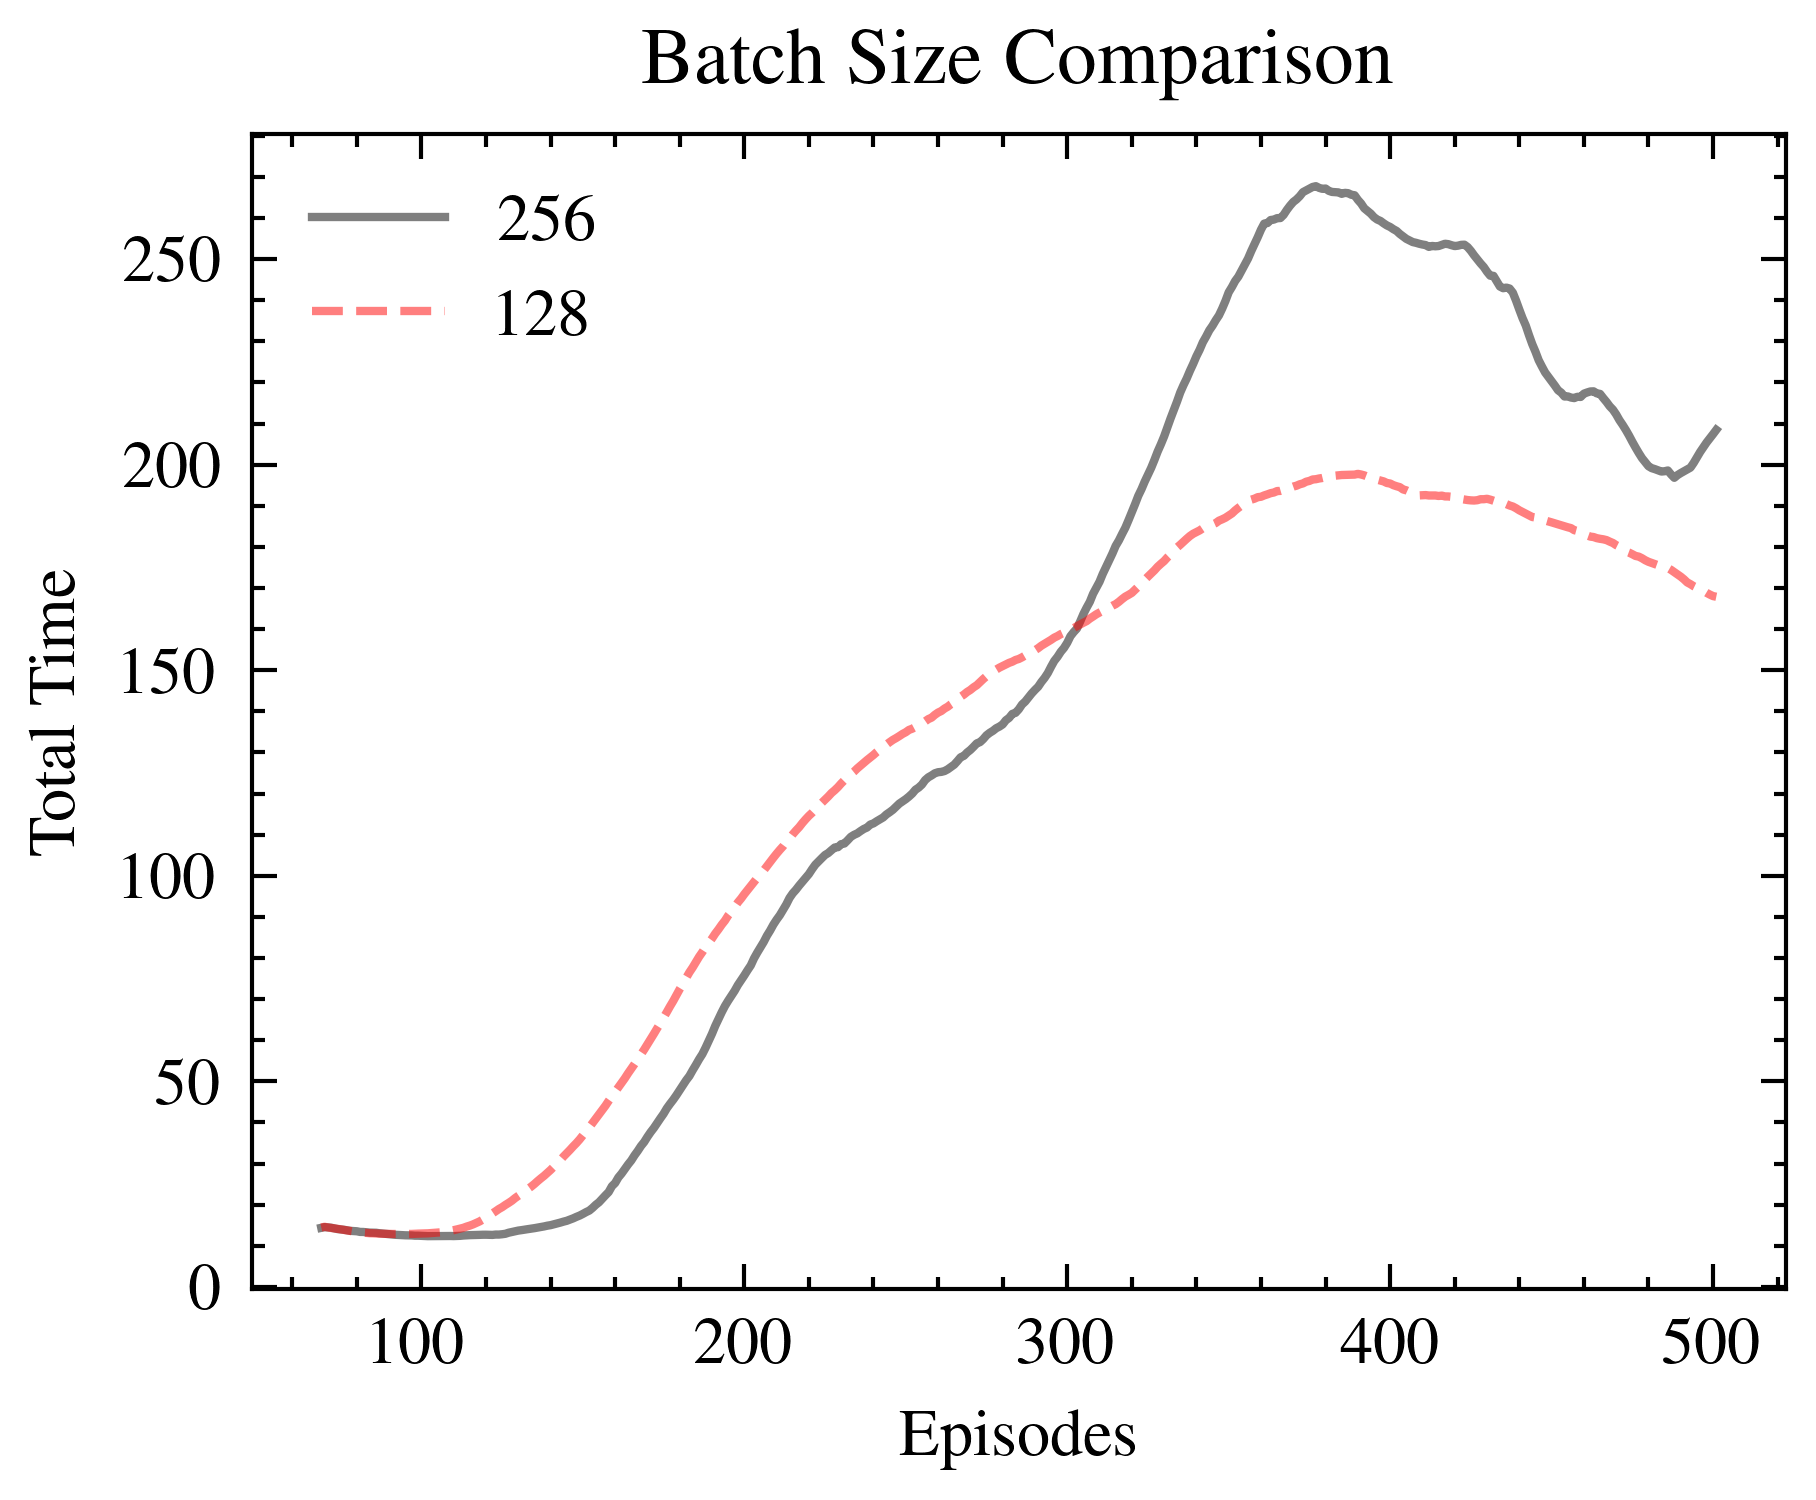

In [12]:
plot_cmp('model_params.batch_size', title='Batch Size Comparison')

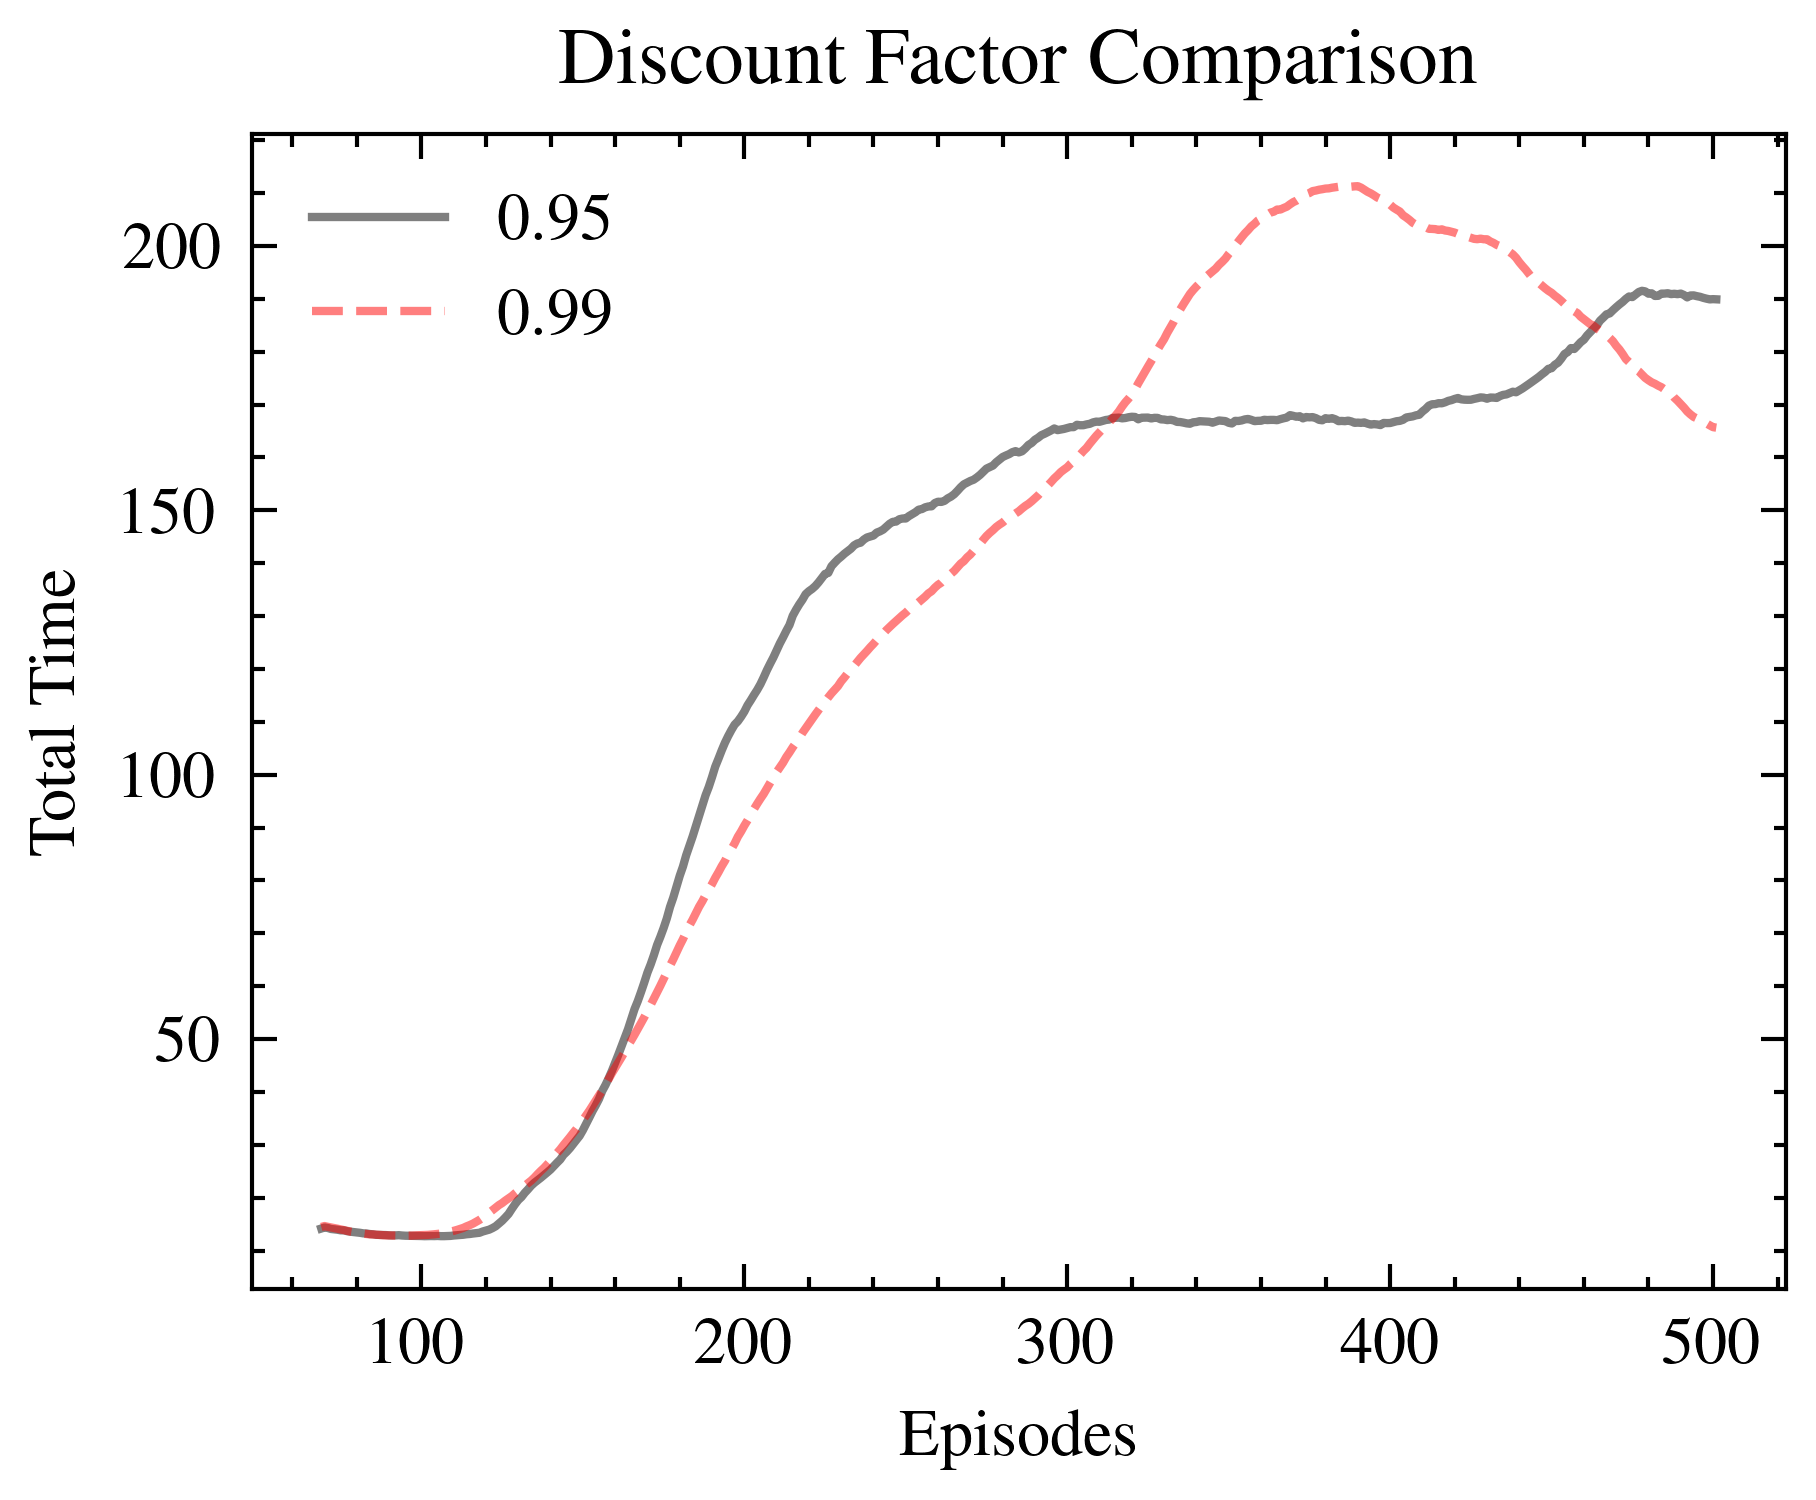

In [15]:
plot_cmp('model_params.gamma', title='Discount Factor Comparison')

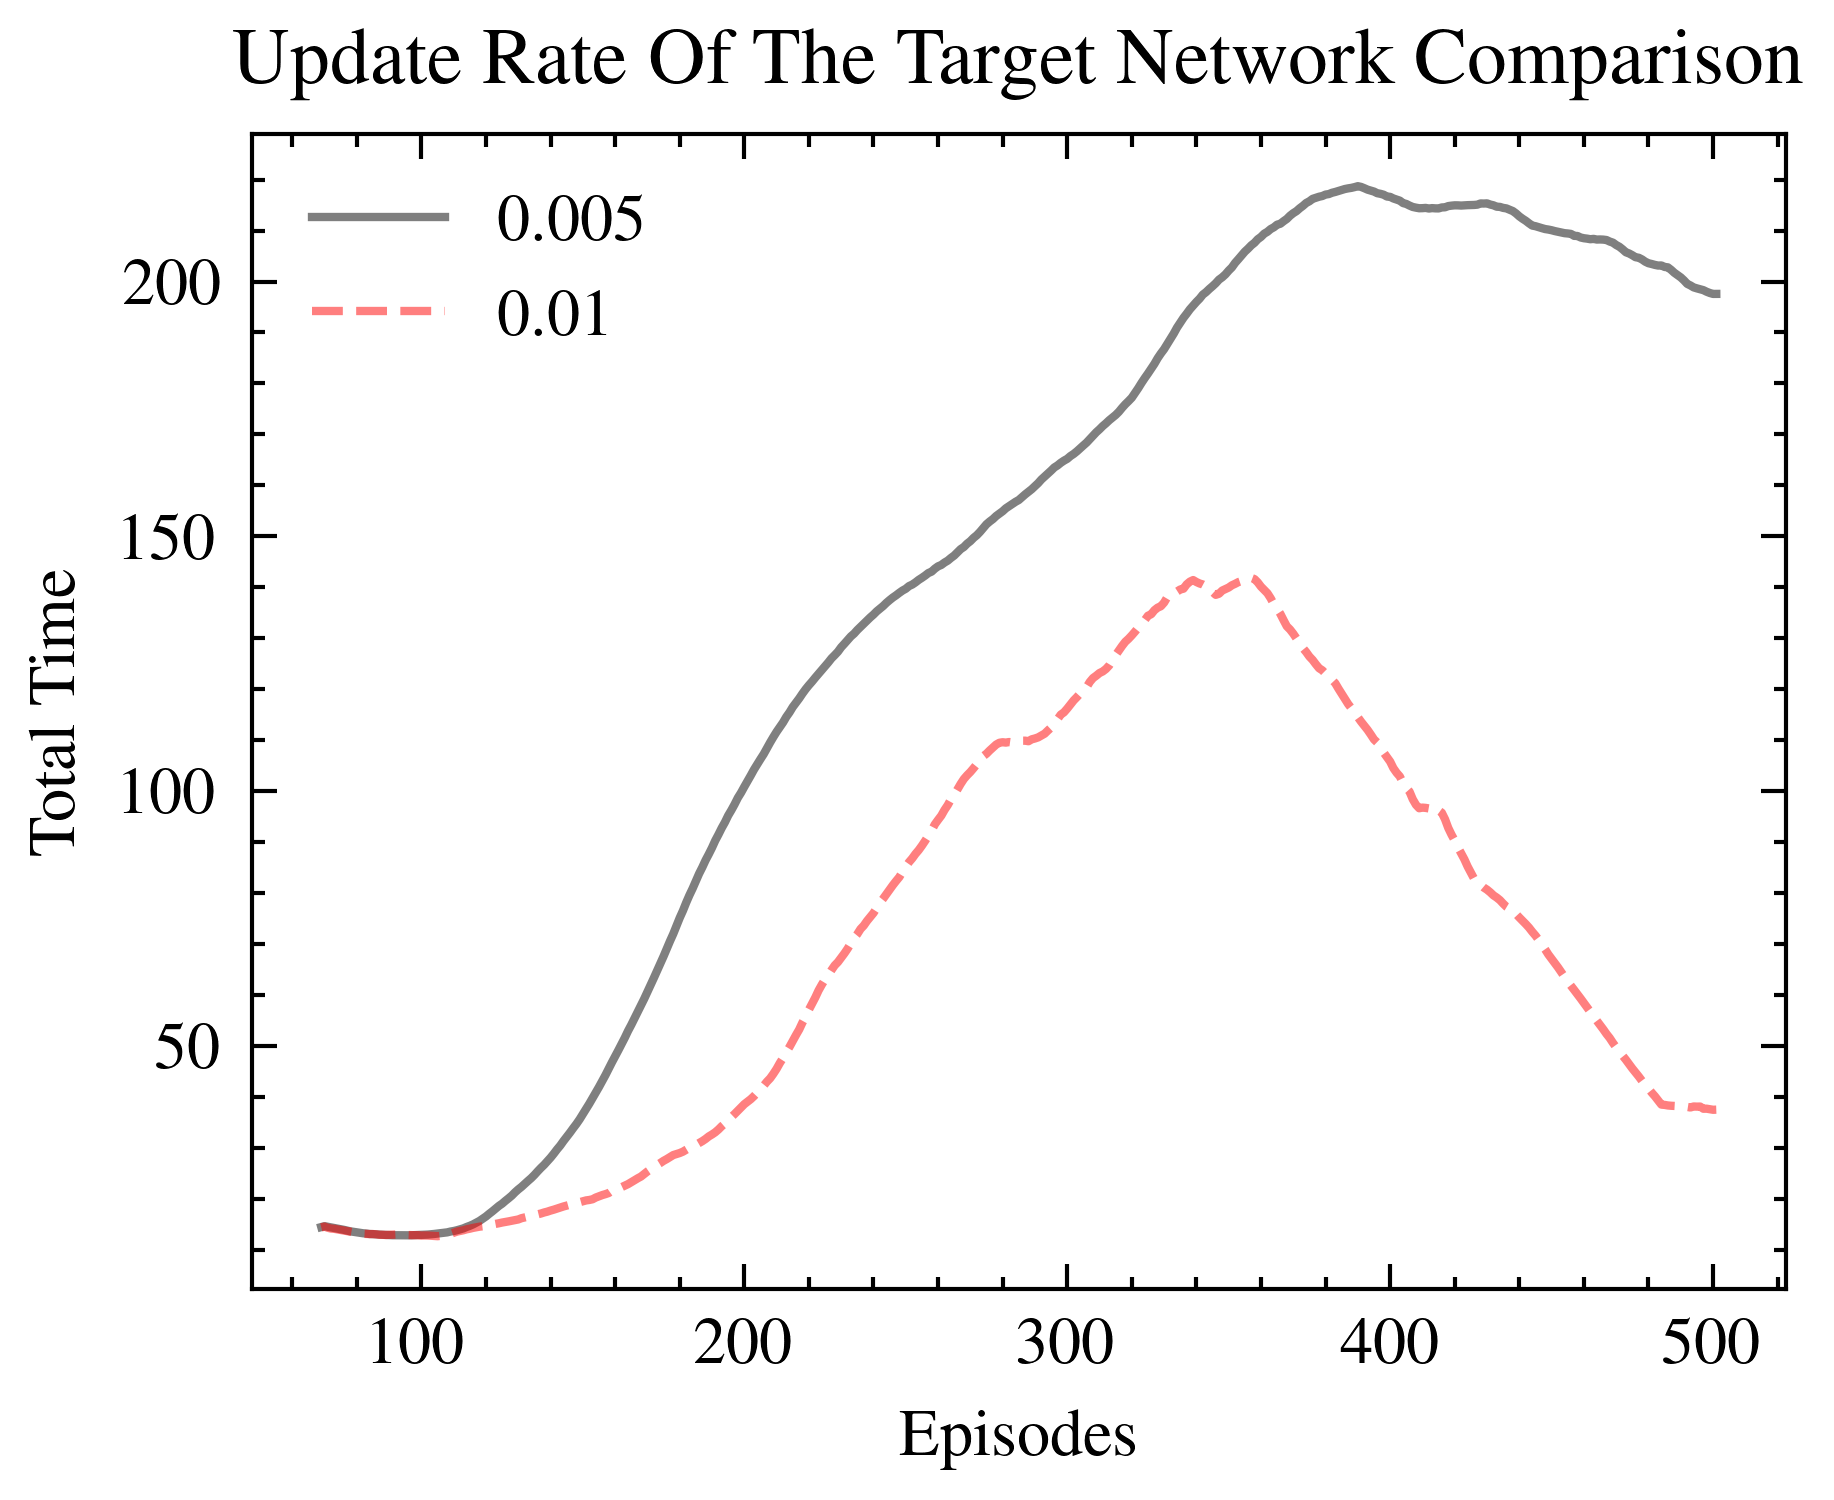

In [16]:
plot_cmp('model_params.tau', title='Update Rate Of The Target Network Comparison')

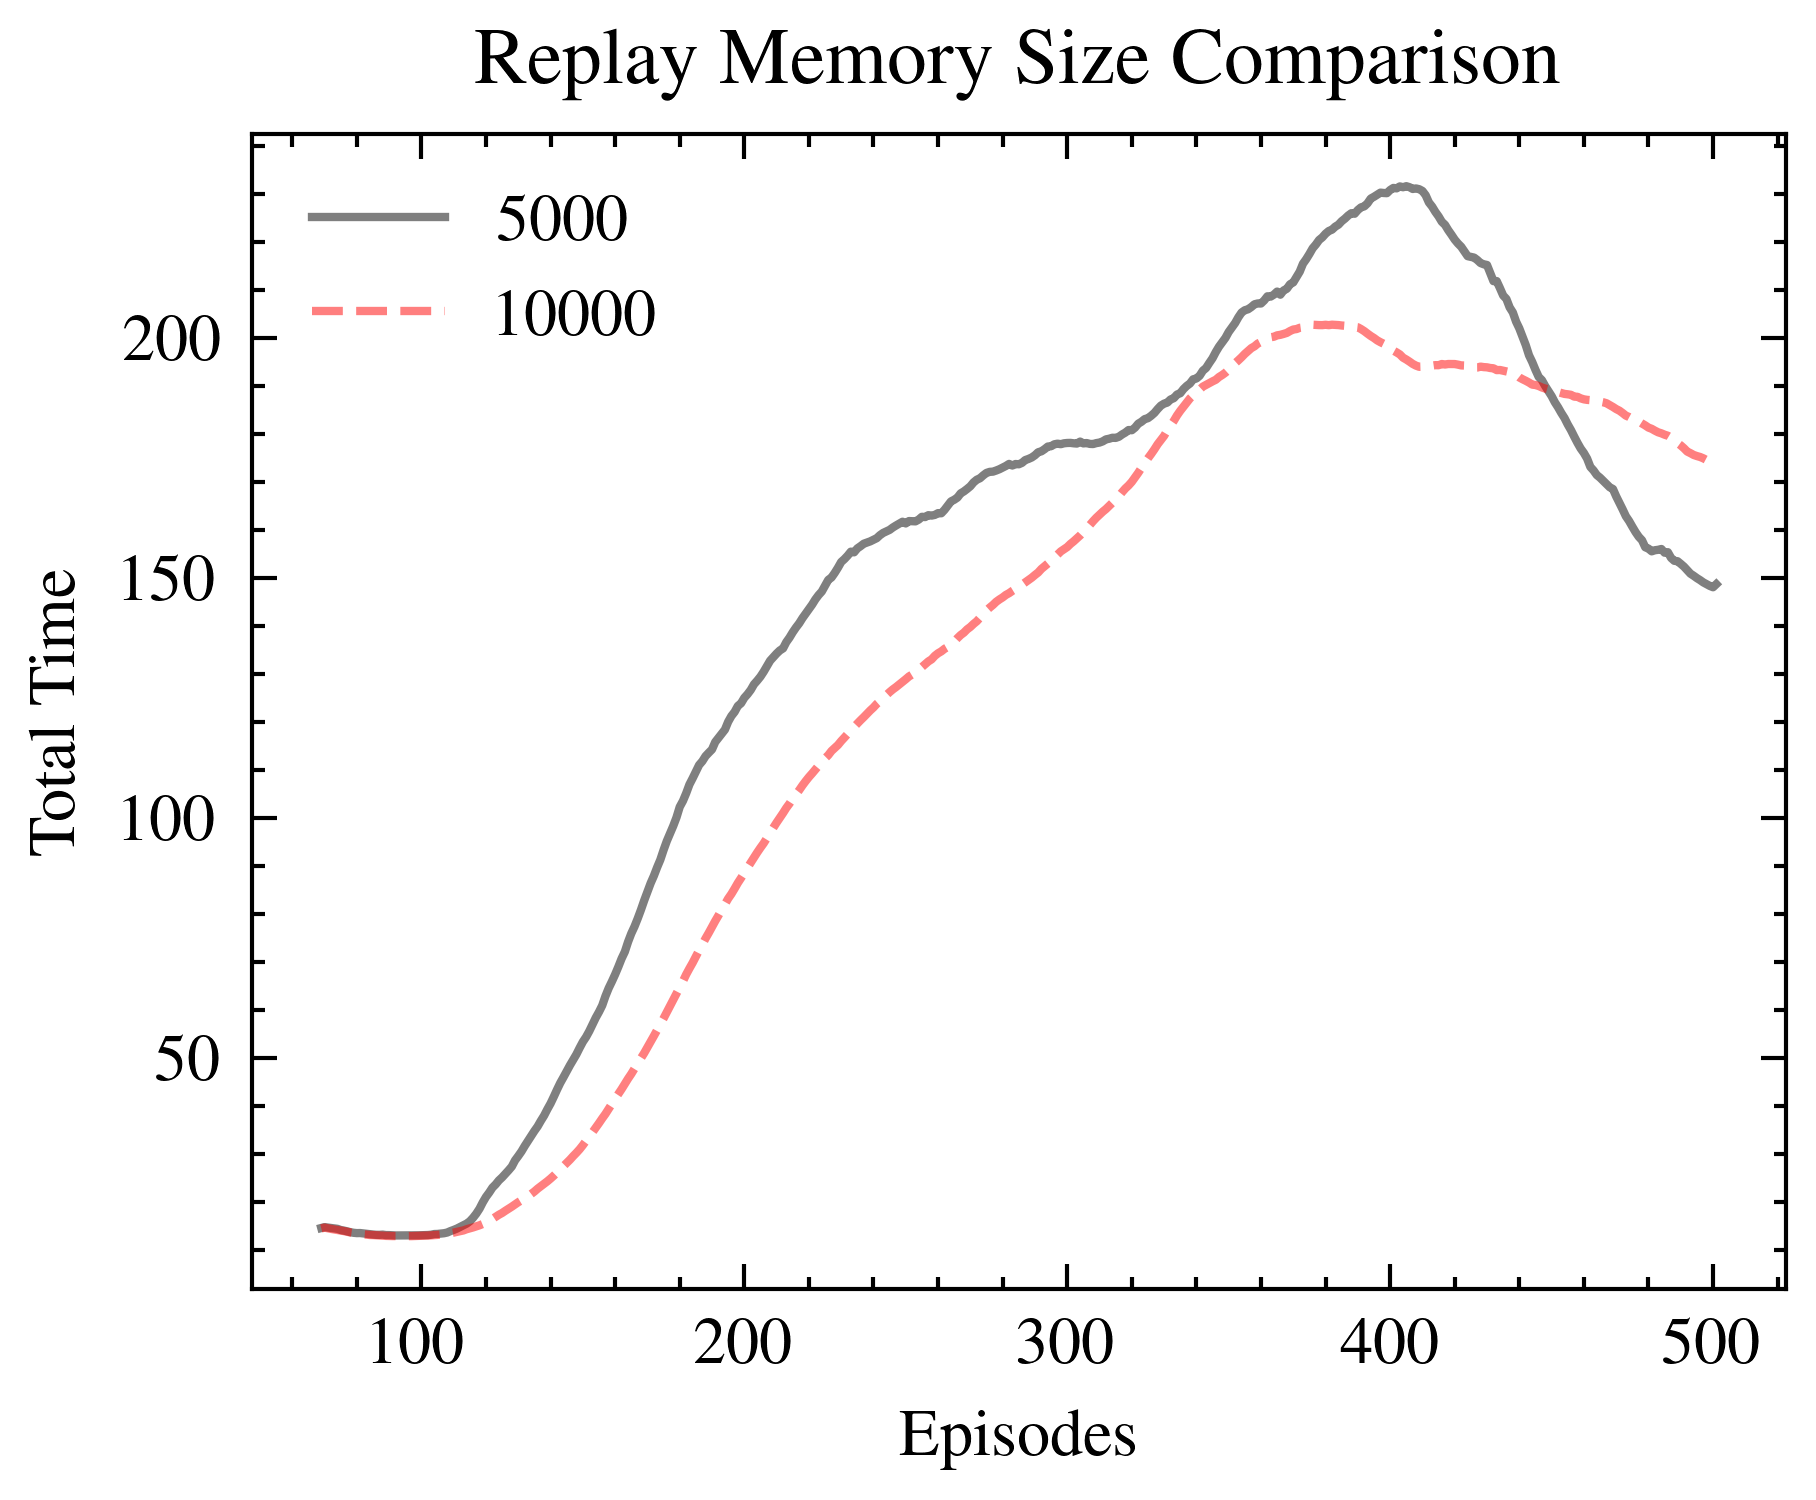

In [17]:
plot_cmp('model_params.memory_size', title='Replay Memory Size Comparison')

---

In [18]:
import math

In [19]:
eps_threshold = [
    0.05
    + (0.9 - 0.05)
    * math.exp(-1. * i / 1000)
    for i in range(int(1E4))
]

Text(0.5, 1.0, 'Exponential Decay Of $\\epsilon$')

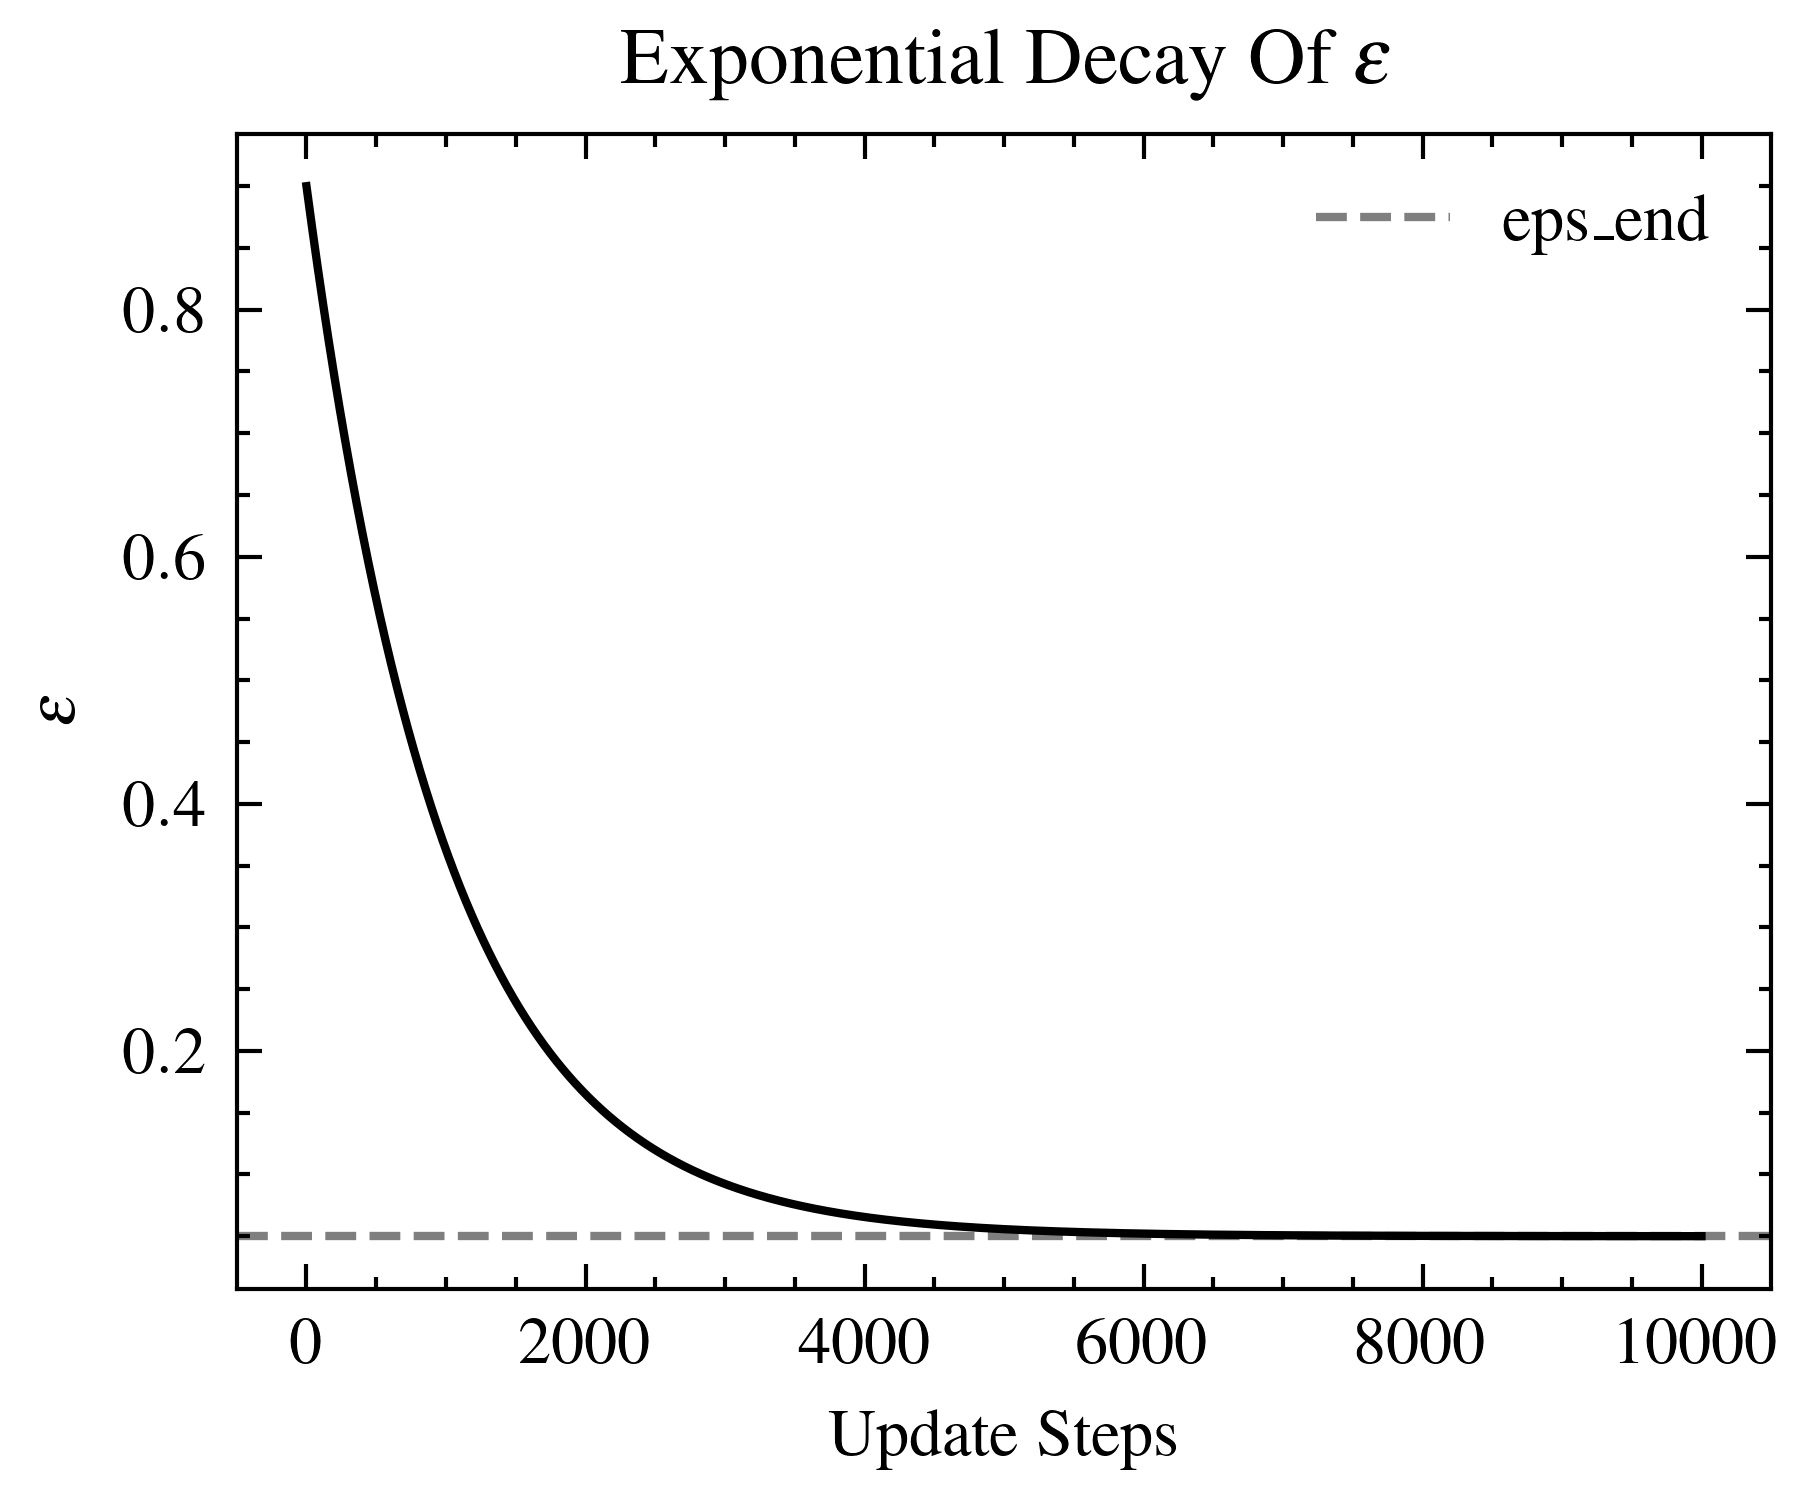

In [20]:
plt.plot(eps_threshold)
plt.axhline(0.05, ls='--', alpha=.5, label='eps_end')
plt.legend()
plt.xlabel('Update Steps')
plt.ylabel('$\\epsilon$')
plt.title('Exponential Decay Of $\\epsilon$')